# ROBOTIC GRASP DETECTION
## Based on 'Robotic Grasp Detection using Deep Convolutional Neural Networks' (Sulabh Kumra and Christopher Kanan, 2017)

In [1]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import shapely.geometry

#!pip install tensorflow==1.12
import tensorflow as tf
#tf.disable_v2_behavior()

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class RotatedRect:
    def __init__(self, rect):
        self.cx = rect[0]
        self.cy = rect[1]
        self.h = rect[2]
        self.w = rect[3]
        self.angle = rect[4]*180/math.pi

    def get_contour(self):
        w = self.w
        h = self.h
        c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
        rc = shapely.affinity.rotate(c, self.angle)
        return shapely.affinity.translate(rc, self.cx, self.cy)

    def intersection(self, other):
        return self.get_contour().intersection(other.get_contour())
    
    def union(self, other):
        return self.get_contour().union(other.get_contour())

In [5]:
def rectangle_metrics(Y_true, Y_predict):
    theta_true = Y_true[:,4]
    theta_predict = Y_predict[:,4]
    
    diff = abs(theta_true-theta_predict)
    score = []
    for i in range(diff.shape[0]):
      if diff[i] > (30*math.pi/180):
        score.append(0)
      else:
        r1 = RotatedRect(Y_true[i,:])
        r2 = RotatedRect(Y_predict[i,:])
        jaccard_coeff = r1.intersection(r2).area/r1.union(r2).area
    
        if jaccard_coeff > 0.25:
          score.append(1)
        else:
          score.append(0)
        
    return np.sum(score)/np.shape(score)

    class RectangleMetrics(Callback):
    #def __init__(self):
        #self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs={}):
        X_val, Y_val_true = self.validation_data[0], self.validation_data[1]
        Y_val_predict = np.asarray(self.model.predict(X_val))
        score = self.calculate_score(Y_val_true, Y_val_predict)
        print('- acc: ', score)

    def calculate_score(self, Y_true, Y_predict):
        theta_true = Y_true[:,4]
        theta_predict = Y_predict[:,4]
        
        diff = abs(theta_true-theta_predict)
        score = []
        for i in range(diff.shape[0]):
          if diff[i] > (30*math.pi/180):
            score.append(0)
          else:
            r1 = RotatedRect(Y_true[i,:])
            r2 = RotatedRect(Y_predict[i,:])
            jaccard_coeff = r1.intersection(r2).area/r1.union(r2).area
        
            if jaccard_coeff > 0.25:
              score.append(1)
            else:
              score.append(0)
            
        return np.sum(score)/np.shape(score)
        def on_test_end(self, logs=None):
        Y_test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        score = self.calculate_score(self.validation_data[1], Y_test_predict)
        print('- acc: ', score)

In [6]:
def bbox_to_grasp(box):
    x = (box[0] + (box[4] - box[0])/2) 
    y = (box[1] + (box[5] - box[1])/2)
    h = math.sqrt(math.pow((box[6] - box[0]), 2) + math.pow((box[7] -box[1]), 2))
    w = math.sqrt(math.pow((box[2] - box[0]), 2) + math.pow((box[3] -box[1]), 2))
    theta = math.atan2(box[2] - box[0], box[3] - box[1])
    if theta < 0:
        theta += math.pi
    return x, y, h, w, theta

def adjust_bboxes(bboxes, ratio , start):
    bboxes_cropped = []
    for i in range(len(bboxes)):
        if not i%2:
            bboxes_cropped.append(bboxes[i]-start)
        else:
            bboxes_cropped.append(bboxes[i])
        #bboxes_cropped.append(bboxes[i])

    bboxes_scaled = [int(i*ratio) for i in bboxes_cropped]
    return bboxes_scaled

def draw_bbox(image, bbox):
    img = image.copy()
    cv2.line(img, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255, 0, 0))
    cv2.line(img, (bbox[2],bbox[3]), (bbox[4],bbox[5]), (0, 0, 255))
    cv2.line(img, (bbox[4],bbox[5]), (bbox[6],bbox[7]), (255, 0, 0))
    cv2.line(img, (bbox[6],bbox[7]), (bbox[0],bbox[1]), (0, 0, 255))
    return img
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def draw_grasp(image, grasp):
    centre = [grasp[0],grasp[1]]
    height, width, theta = grasp[2], grasp[3], grasp[4]
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    p1 = [ + height / 2,  + width / 2]
    p2 = [- height / 2,  + width / 2]
    p3 = [ - height / 2, - width / 2]
    p4 = [ + height / 2,  - width / 2]
    p1_new = np.dot(p1, R)+ centre
    p2_new = np.dot(p2, R)+ centre
    p3_new = np.dot(p3, R)+ centre
    p4_new = np.dot(p4, R)+ centre
    
    bbox = [p1_new, p2_new, p3_new, p4_new]
    bbox = np.array(bbox)
    bbox = bbox.reshape((1,8))[0].astype(int)
    return draw_bbox(image,bbox)

### Data loading and preprocessing
#### Five-fold cross validation (image-wise split)


In [7]:
X_train_fold =	{0: [], 1: [], 2: [], 3: [], 4: []}
Y_train_fold =	{0: [], 1: [], 2: [], 3: [], 4: []}

X_test = []
Y_test = []

i = 0
for img_path in glob.glob("/content/drive/MyDrive/coronell_dataset/grasp- 5 11/*.png"):
    img = cv2.imread(img_path)
    if img.shape[0]==720:
      ratio= 224/720
      start=280
      img = img[:,280:1000,:] # crop to (480,480) in order to preserve aspect ratio when resizing
    else:
      ratio= 224/480
      start=80
      img = img[:,80:560,:] # crop to (480,480) in order to preserve aspect ratio when resizing
    img = cv2.resize(img,(224,224))
    
    bbox_path = img_path.split('.')[0][:]+'_annotations.txt'
    with open(bbox_path, 'r') as f:
        bboxes_list = list(map(lambda coordinate: float(coordinate), f.read().strip().split()))
        bboxes = adjust_bboxes(bboxes_list, ratio, start)

    if not i%6:
        for j in range(int(len(bboxes)/8)):
            X_test.append(img)
            Y_test.append(bbox_to_grasp(bboxes[j*8:j*8+8]))
    else:
        for j in range(int(len(bboxes)/8)):
            X_train_fold[i%5].append(img)
            Y_train_fold[i%5].append(bbox_to_grasp(bboxes[j*8:j*8+8]))
    i += 1

    
for i in range(5):
  X_train_fold[i] = np.array(X_train_fold[i])
  Y_train_fold[i] = np.array(Y_train_fold[i])

X_test = np.array(X_test)
Y_test = np.array(Y_test)

#### Zapravo je ukupan broj slika u datasetu 885, ali je 5k označenih točnih pravokutnika

In [ ]:
train_images = 0
for x, y in X_train_fold.items():
  print("Fold {} contains {} images.\n".format(x, y.shape[0])) 
  train_images += y.shape[0]

print("There are {} train images and {} test images.".format(train_images, X_test.shape[0]))

Fold 0 contains 40 images.

Fold 1 contains 38 images.

Fold 2 contains 41 images.

Fold 3 contains 38 images.

Fold 4 contains 46 images.

There are 203 train images and 42 test images.


In [13]:
X_train_fold[1].shape[1:]

(224, 224, 3)

Shape of each image in the training data:  (224, 224, 3)


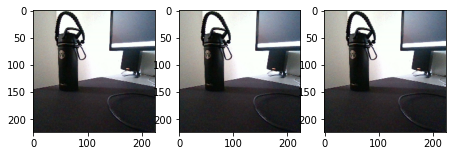

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(1, 4):
    img = X_train_fold[1][1]
    fig.add_subplot(2, 4, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print('Shape of each image in the training data: ', X_train_fold[1].shape[1:])

Grasp example


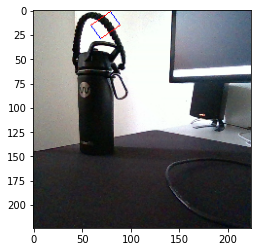

In [ ]:
img = X_train_fold[1][1]
plt.imshow(cv2.cvtColor(draw_grasp(img,Y_train_fold[1][1]), cv2.COLOR_BGR2RGB))
print('Grasp example')

### Model architecture

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [11]:

train_features_fold = {0: [], 1: [], 2: [], 3: [], 4: []}

for i in range(5):
  X_train_fold[i] = preprocess_input(X_train_fold[i])
  train_features_fold[i] = base_model.predict(X_train_fold[i])

X_test_pp = preprocess_input(X_test)
test_features = base_model.predict(X_test_pp)

In [ ]:
top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=train_features_fold[1].shape[1:]))
top_model.add(Dense(1024, activation='relu', kernel_initializer="glorot_normal", bias_initializer="glorot_normal"))
top_model.add(Dropout(0.2))
top_model.add(Dense(5, activation='relu', kernel_initializer="glorot_normal", bias_initializer="glorot_normal"))

top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 2,103,301
Trainable params: 2,103,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
top_model.compile(loss='mse', optimizer=sgd)

### Training and evaluation - top layers

In [ ]:
epochs = 30
for i in range(int(epochs/5)):
  for j in range(5):
    print('Epoch {}/{}'.format(i*5+j+1,epochs))
    top_model.fit(x = np.concatenate((train_features_fold[(j+1)%5], train_features_fold[(j+2)%5], train_features_fold[(j+3)%5], train_features_fold[(j+4)%5])), 
                  y = np.concatenate((Y_train_fold[(j+1)%5], Y_train_fold[(j+2)%5], Y_train_fold[(j+3)%5], Y_train_fold[(j+4)%5])),
                  batch_size=32, validation_data = (train_features_fold[j],Y_train_fold[j]), verbose=1, shuffle=True)

Epoch 1/30
6/6 [==============================] - 1s 79ms/step - loss: 4218.8614 - val_loss: 2751.6082
Epoch 2/30
6/6 [==============================] - 0s 20ms/step - loss: 3339.4287 - val_loss: 3566.6973
Epoch 3/30
6/6 [==============================] - 0s 22ms/step - loss: 3283.7539 - val_loss: 3427.7427
Epoch 4/30
6/6 [==============================] - 0s 20ms/step - loss: 3511.6331 - val_loss: 3422.7031
Epoch 5/30
5/5 [==============================] - 0s 24ms/step - loss: 3322.0962 - val_loss: 2993.7546
Epoch 6/30
6/6 [==============================] - 0s 19ms/step - loss: 3899.5530 - val_loss: 2835.2559
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 3030.6128 - val_loss: 3388.0527
Epoch 8/30
6/6 [==============================] - 0s 20ms/step - loss: 2994.6155 - val_loss: 3037.1306
Epoch 9/30
6/6 [==============================] - 0s 19ms/step - loss: 2883.8433 - val_loss: 2976.9832
Epoch 10/30
5/5 [==============================] - 0s 25ms/step - loss: 2

In [ ]:
print('Evaluate on test data')
results = top_model.evaluate(test_features, Y_test, batch_size=128)
print('test loss: ', results)

Y_predict = np.asarray(top_model.predict(test_features))
acc = rectangle_metrics(Y_test, Y_predict)
print('acc: ', acc)

Evaluate on test data
1/1 [==============================] - 0s 21ms/step - loss: 1419.1021
test loss:  1419.10205078125
acc:  [0.]


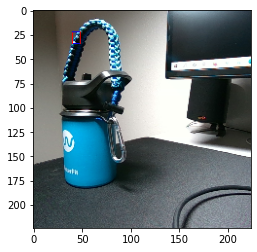

In [ ]:
y = top_model.predict(np.expand_dims(test_features[1],0))
plt.imshow(cv2.cvtColor(draw_grasp(X_test[1],y[0]), cv2.COLOR_BGR2RGB))

### Final model

In [ ]:
base_model.trainable = True
base_model_input = Input((224,224,3))
base_model_output = base_model(base_model_input)
top_model_output = top_model(base_model_output)

model = Model(base_model_input, top_model_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 2103301   
Total params: 25,691,013
Trainable params: 25,637,893
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd, loss='mse')

In [ ]:
epochs = 100
checkpoint_path = "/content/drive/MyDrive/diplomski/checkpoint/cp.ckpt"
for i in range(int(epochs/5)):
  for j in range(5):
    print('Epoch {}/{}'.format(i*5+j+1,epochs))
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    model.fit(x = np.concatenate((X_train_fold[(j+1)%5], X_train_fold[(j+2)%5], X_train_fold[(j+3)%5], X_train_fold[(j+4)%5])), 
              y = np.concatenate((Y_train_fold[(j+1)%5], Y_train_fold[(j+2)%5], Y_train_fold[(j+3)%5], Y_train_fold[(j+4)%5])),
              batch_size=32, validation_data = (X_train_fold[j],Y_train_fold[j]),callbacks=[cp_callback], shuffle=True)

Epoch 1/100
6/6 [==============================] - 1s 177ms/step - loss: 134.8212 - val_loss: 230.3886

Epoch 00001: saving model to /content/drive/MyDrive/diplomski/checkpoint/cp.ckpt
Epoch 2/100
6/6 [==============================] - 1s 174ms/step - loss: 114.1126 - val_loss: 399.4465

Epoch 00001: saving model to /content/drive/MyDrive/diplomski/checkpoint/cp.ckpt
Epoch 3/100
6/6 [==============================] - 1s 170ms/step - loss: 117.1686 - val_loss: 166.4179

Epoch 00001: saving model to /content/drive/MyDrive/diplomski/checkpoint/cp.ckpt
Epoch 4/100
6/6 [==============================] - 1s 219ms/step - loss: 104.5109 - val_loss: 275.3503

Epoch 00001: saving model to /content/drive/MyDrive/diplomski/checkpoint/cp.ckpt
Epoch 5/100
5/5 [==============================] - 1s 211ms/step - loss: 93.7690 - val_loss: 213.2120

Epoch 00001: saving model to /content/drive/MyDrive/diplomski/checkpoint/cp.ckpt
Epoch 6/100
6/6 [==============================] - 1s 169ms/step - loss: 99.

In [ ]:
print('Evaluate on test data')
results = model.evaluate(X_test_pp, Y_test, batch_size=128)
print('test loss: ', results)

Y_predict = np.asarray(model.predict(X_test_pp))
acc = rectangle_metrics(Y_test, Y_predict)
print('acc: ', acc)

Evaluate on test data
1/1 [==============================] - 0s 336ms/step - loss: 74.0735
test loss:  74.07349395751953
acc:  [0.26190476]


In [ ]:
Y_predict[0:15]

array([[ 64.793175 ,  26.249166 ,  16.18406  ,  31.105564 ,   1.5157759],
       [ 64.793175 ,  26.249166 ,  16.18406  ,  31.105564 ,   1.5157759],
       [122.066376 ,  75.50227  ,  17.471684 ,  21.476513 ,   1.1313126],
       [122.066376 ,  75.50227  ,  17.471684 ,  21.476513 ,   1.1313126],
       [133.94382  ,  79.31562  ,  18.695202 ,  24.643433 ,   1.5750473],
       [133.94382  ,  79.31562  ,  18.695202 ,  24.643433 ,   1.5750473],
       [121.58824  ,  75.82337  ,  17.335712 ,  21.820292 ,   1.1423855],
       [121.58824  ,  75.82337  ,  17.335712 ,  21.820292 ,   1.1423855],
       [119.872025 ,  79.51243  ,  16.439913 ,  24.687687 ,   1.3326943],
       [119.872025 ,  79.51243  ,  16.439913 ,  24.687687 ,   1.3326943],
       [117.47298  ,  94.25294  ,  15.18071  ,  20.413368 ,   1.1514809],
       [117.47298  ,  94.25294  ,  15.18071  ,  20.413368 ,   1.1514809],
       [119.03984  ,  95.16599  ,  15.282309 ,  20.444723 ,   1.1803262],
       [119.03984  ,  95.16599  ,  15.

[[133.9438     79.31561    18.695202   24.643433    1.5750477]]


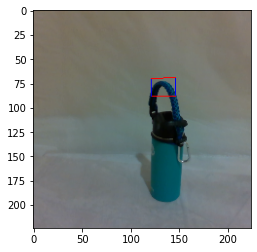

In [ ]:
img_expanded = np.expand_dims(X_test_pp[4], 0)
y = model.predict(img_expanded)
print (y)
plt.imshow(cv2.cvtColor(draw_grasp(X_test[4],y[0]), cv2.COLOR_BGR2RGB))

In [ ]:
os.makedirs('./drive/My Drive/diplomski/model', exist_ok=True)
model.save('./drive/My Drive/diplomski/model/grasp_model.h5')

In [ ]:
model.save('./drive/My Drive/diplomski/model')

INFO:tensorflow:Assets written to: ./drive/My Drive/diplomski/model/assets


In [ ]:
!cd "./drive/My Drive/diplomski/model/"
!ls grasp_model

ls: cannot access 'grasp_model': No such file or directory
